In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import ROOT as rt
# import csv
# import re
# import sys
# import collections

# from collections import OrderedDict
# import uproot
# import pandas as pd

# import scipy
# import awkward
import numpy as np
# import time
# import numba
# from numba import jit
# from matplotlib import pyplot as plt

from src import CMS_lumi, tdrstyle
# from src.histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from typing import Iterable


from build_rdf import *

rt.ROOT.EnableImplicitMT()
tdr = tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

rt.gStyle.SetOptFit(1011)
rt.gStyle.SetOptStat(0)

wH = 1
Z_MASS = 91.2
gc = []

data_year = 'full'
years = ['Run3_Fall22']
fpath = 'data/raw/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
tree_name = 'MuonSystem'

lat = rt.TLatex()
lat.SetTextSize(0.04)
lat.SetTextAlign(11)

rdf_raw = rt.RDataFrame(tree_name, fpath)
#Remove signal region
rdf_bkg = apply_size_cut(rdf_raw, 1, 100, 'csc') 
rdf_bkg = apply_size_cut(rdf_bkg, 1, 100, 'dt')

rdf_sig = apply_size_cut(rdf_raw, 101, 100_000, 'csc')
rdf_sig = apply_size_cut(rdf_sig, 101, 100_000, 'dt')

#####################

# print(rdf_bkg.Count().GetValue())
# print(rdf_bkg.Filter('(nJets == 0) && (nLeptons == 0)').Count().GetValue())
# print(apply_match_cut(rdf_bkg).Count().GetValue())
# print(apply_match_cut(rdf_bkg.Filter('(nJets == 0) && (nLeptons == 0)')).Count().GetValue())

rdf = rdf_raw.Filter('(nJets == 0)')# && (nLeptons == 0)')
# rdf = rdf_bkg.Filter('(nJets == 0)')# && (nLeptons == 0)')

rdf = rdf.Define('cscCluster0Size', 'cscRechitClusterSize[0]')
rdf = rdf.Define('cscCluster1Size', 'cscRechitClusterSize[1]')
rdf = rdf.Define('dtCluster0Size', 'dtRechitClusterSize[0]')
rdf = rdf.Define('dtCluster1Size', 'dtRechitClusterSize[1]')

rdf50 = rdf.Filter('met > 50')
rdf200 = rdf.Filter('met > 200')

# ###
# all_cut = rdf_raw.Filter('nCscRechitClusters + nDtRechitClusters == 2')
# all_good = apply_match_cut(all_cut).Filter('nCscRechitClusters + nDtRechitClusters == 2')
# print(all_good.Count().GetValue()/all_cut.Count().GetValue())
# ###

date = 'jan30'

Welcome to JupyROOT 6.26/10


input_line_183:2:87: warning: implicit conversion from 'long' to 'int' changes value from 9999999999999 to 1316134911 [-Wconstant-conversion]
auto lambda7 = [](ROOT::VecOps::RVec<Int_t>& var0){return Numba::_size_cut(var0, 101, 9999999999999)
                                                          ~~~~~                       ^~~~~~~~~~~~~


In [2]:
nb = 10
bins1D = (nb, 30, 800)
bins2D = (nb, 30, 800, nb, 30, 800)


c1 = rt.TCanvas('c1','c1',7*800,3*800); c1.Divide(7,3)
c1.Draw()

tts = [
    [rdf, 'Sim Signal: 2 clusters only, no jets/leps'],
    [rdf50, 'Sim Signal: 2 clusters only, no jets/leps, ME_{t} > 50 GeV'],
    [rdf200, 'Sim Signal: 2 clusters only, no jets/leps, ME_{t} > 200 GeV'],
]
for irdf, (_rdf, tt)in enumerate(tts):
    _rdf = _rdf.Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')
    _rdfM = apply_match_cut(_rdf).Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')
    hhs = [
        [_rdf.Histo1D(('csc','Cluster Size;size',*bins1D),'cscRechitClusterSize'), 
        _rdf.Histo1D(('dt','Cluster Size;size',*bins1D),'dtRechitClusterSize'),
        _rdfM.Histo1D(('cscmat','Cluster Size;size',*bins1D),'cscRechitClusterSize'), 
        _rdfM.Histo1D(('dtmat','Cluster Size;size',*bins1D),'dtRechitClusterSize')
        ],
        _rdf.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dt','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size', 'cscCluster1Size'),
        _rdf.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dt','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size'),
        _rdf.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dt','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size'),
        _rdfM.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dtmat','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size', 'cscCluster1Size'),
        _rdfM.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dtmat','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size'),
        _rdfM.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dtmat','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size'),
    ]


    lat.SetTextAlign(33)
    lat.SetTextColor(rt.kBlack)
    for ih, hh in enumerate(hhs):
        c1.cd(irdf*len(hhs)+ ih + 1)
        if isinstance(hh, Iterable):
            ymax = max([h.GetMaximum()for h in hh])
            for h in hh:
                h.SetLineWidth(4)
                if 'csc' in h.GetName():
                    h.SetLineWidth(6)
                    h.SetLineColor(rt.kBlue)
                else:
                    h.SetLineColor(rt.kRed)
                if 'mat' in h.GetName():
                    h.SetLineStyle(2)
                h.SetMaximum(ymax*1.05)
                h.Draw('same')
                # h.DrawNormalized('same')
            
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(0.95, 0.93, f'NEvents - {_rdf.Count().GetValue():,.0f}')
            lat.SetTextColor(rt.kBlue)
            lat.DrawLatexNDC(0.95, 0.89, 'CSC')
            lat.SetTextColor(rt.kRed)
            lat.DrawLatexNDC(0.95, 0.85, 'DT')
        else:
            c1.cd(irdf*len(hhs)+ ih + 1).SetLogz()
            hh.Draw('coltext')
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(1, 1, f'NEvents - {hh.Integral():,.0f}')
            if 'mat' in hh.GetName():
                lat.SetTextAlign(13)
                lat.DrawLatexNDC(0.1, 1, 'Matched')

    lat.SetTextAlign(13)
    c1.cd(irdf*len(hhs)+ 1)
    # lat.SetTextColor(rt.kRed)
    lat.DrawLatexNDC(0,1, tt)

    gc.extend(hhs)

c1.Print(f'reports/weekly/{date}/cluster_sizes.png')


Info in <TCanvas::Print>: png file reports/weekly/jan30/cluster_sizes.png has been created


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file reports/weekly/jan30/cluster_sizes_acceptance.png has been created


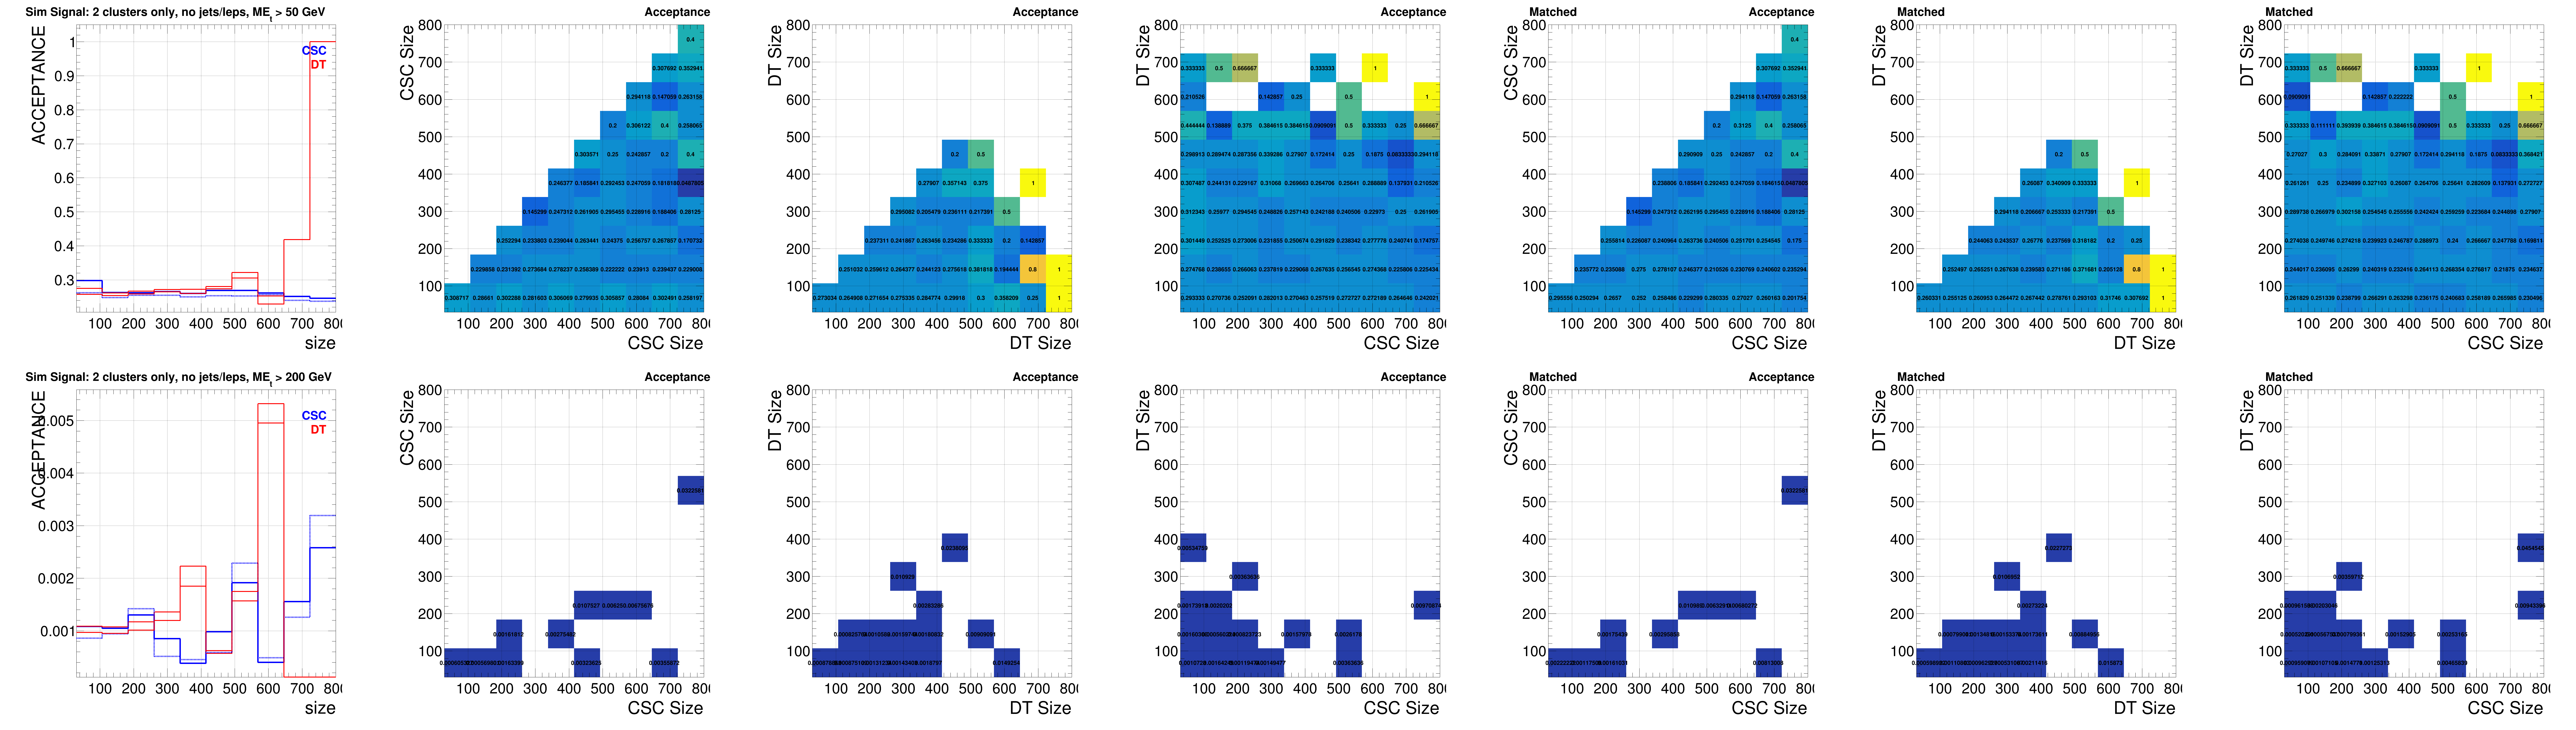

In [3]:
rdfA = rdf.Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')
rdfM = apply_match_cut(rdfA).Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')

c1 = rt.TCanvas('c1','c1',7*800,2*800); c1.Divide(7,2)
c1.Draw()

tts = [
    [rdf50, 'Sim Signal: 2 clusters only, no jets/leps, ME_{t} > 50 GeV'],
    [rdf200, 'Sim Signal: 2 clusters only, no jets/leps, ME_{t} > 200 GeV'],
]
for irdf, (_rdf, tt)in enumerate(tts):
    _rdf = _rdf.Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')
    _rdf_matched = apply_match_cut(_rdf).Filter('(nCscRechitClusters == 2)|| (nDtRechitClusters == 2)|| (nCscRechitClusters + nDtRechitClusters == 2)')


    csc1D  = _rdf.Histo1D(('csc','Cluster Size;size;ACCEPTANCE',*bins1D),'cscRechitClusterSize')
    cscM1D = _rdf_matched.Histo1D(('cscmat','Cluster Size;size;ACCEPTANCE',*bins1D),'cscRechitClusterSize')
    
    dt1D   = _rdf.Histo1D(('dt','Cluster Size;size',*bins1D),'dtRechitClusterSize')
    dtM1D  = _rdf_matched.Histo1D(('dt','Cluster Size;size',*bins1D),'dtRechitClusterSize')

    csc1D.Divide( rdfA.Histo1D(('csc','Cluster Size;size',*bins1D),'cscRechitClusterSize').GetPtr())
    cscM1D.Divide(rdfM.Histo1D(('cscmat','Cluster Size;size',*bins1D),'cscRechitClusterSize').GetPtr())
    
    dt1D.Divide(  rdfA.Histo1D(('dt','Cluster Size;size',*bins1D),'dtRechitClusterSize').GetPtr())
    dtM1D.Divide( rdfM.Histo1D(('dt','Cluster Size;size',*bins1D),'dtRechitClusterSize').GetPtr())


    csccsc = _rdf.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dt','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size','cscCluster1Size')
    cscdt = _rdf.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dt','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size')
    dtdt = _rdf.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dt','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size')
    csccscM = _rdf_matched.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dtmat','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size','cscCluster1Size')
    cscdtM = _rdf_matched.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dtmat','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size')
    dtdtM = _rdf_matched.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dtmat','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size')


    csccsc.Divide(rdfA.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dt','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size','cscCluster1Size').GetPtr())
    cscdt.Divide(rdfA.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dt','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size').GetPtr())
    dtdt.Divide(rdfA.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dt','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size').GetPtr())
    csccscM.Divide(rdfM.Filter('(nCscRechitClusters == 2)&& (nDtRechitClusters == 0)').Histo2D(('2csc0dtmat','2 CSC, 0 DT;CSC Size;CSC Size', *bins2D), 'cscCluster0Size','cscCluster1Size').GetPtr())
    cscdtM.Divide(rdfM.Filter('(nCscRechitClusters == 0)&& (nDtRechitClusters == 2)').Histo2D(('0csc2dtmat','0 CSC, 2 DT;DT Size;DT Size', *bins2D), 'dtCluster0Size', 'dtCluster1Size').GetPtr())
    dtdtM.Divide(rdfM.Filter('(nCscRechitClusters == 1)&& (nDtRechitClusters == 1)').Histo2D(('1csc1dtmat','1 CSC, 1 DT;CSC Size;DT Size', *bins2D), 'cscCluster0Size', 'dtCluster0Size').GetPtr())
    

    hhs = [
        [csc1D, dt1D, cscM1D, dtM1D],
        csccsc,
        cscdt,
        dtdt,
        csccscM,
        cscdtM,
        dtdtM,
    ]

    lat.SetTextAlign(33)
    lat.SetTextColor(rt.kBlack)
    for ih, hh in enumerate(hhs):
        c1.cd(irdf*len(hhs)+ ih + 1)
        if isinstance(hh, Iterable):
            ymax = max([h.GetMaximum()for h in hh])
            for h in hh:
                h.SetLineWidth(4)
                if 'csc' in h.GetName():
                    h.SetLineColor(rt.kBlue)
                    h.SetLineWidth(6)
                else:
                    h.SetLineColor(rt.kRed)
                if 'mat' in h.GetName():
                    h.SetLineStyle(2)
                h.SetMaximum(ymax*1.05)
                h.Draw('same')
                # h.DrawNormalized('same')
            
            lat.SetTextColor(rt.kBlack)
            lat.SetTextColor(rt.kBlue)
            lat.DrawLatexNDC(0.95, 0.89, 'CSC')
            lat.SetTextColor(rt.kRed)
            lat.DrawLatexNDC(0.95, 0.85, 'DT')
        else:
            c1.cd(irdf*len(hhs)+ ih + 1)#.SetLogz()
            hh.SetMinimum(0)
            hh.SetMaximum(1)
            hh.Draw('coltext')
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(1, 1, 'Acceptance')
            if 'mat' in hh.GetName():
                lat.SetTextAlign(13)
                lat.DrawLatexNDC(0.1, 1, 'Matched')

    lat.SetTextAlign(13)
    c1.cd(irdf*len(hhs)+ 1)
    # lat.SetTextColor(rt.kRed)
    lat.DrawLatexNDC(0,1, tt)

    gc.extend(hhs)

c1.Print(f'reports/weekly/{date}/cluster_sizes_acceptance.png')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file reports/weekly/jan30/n_clusters.png has been created


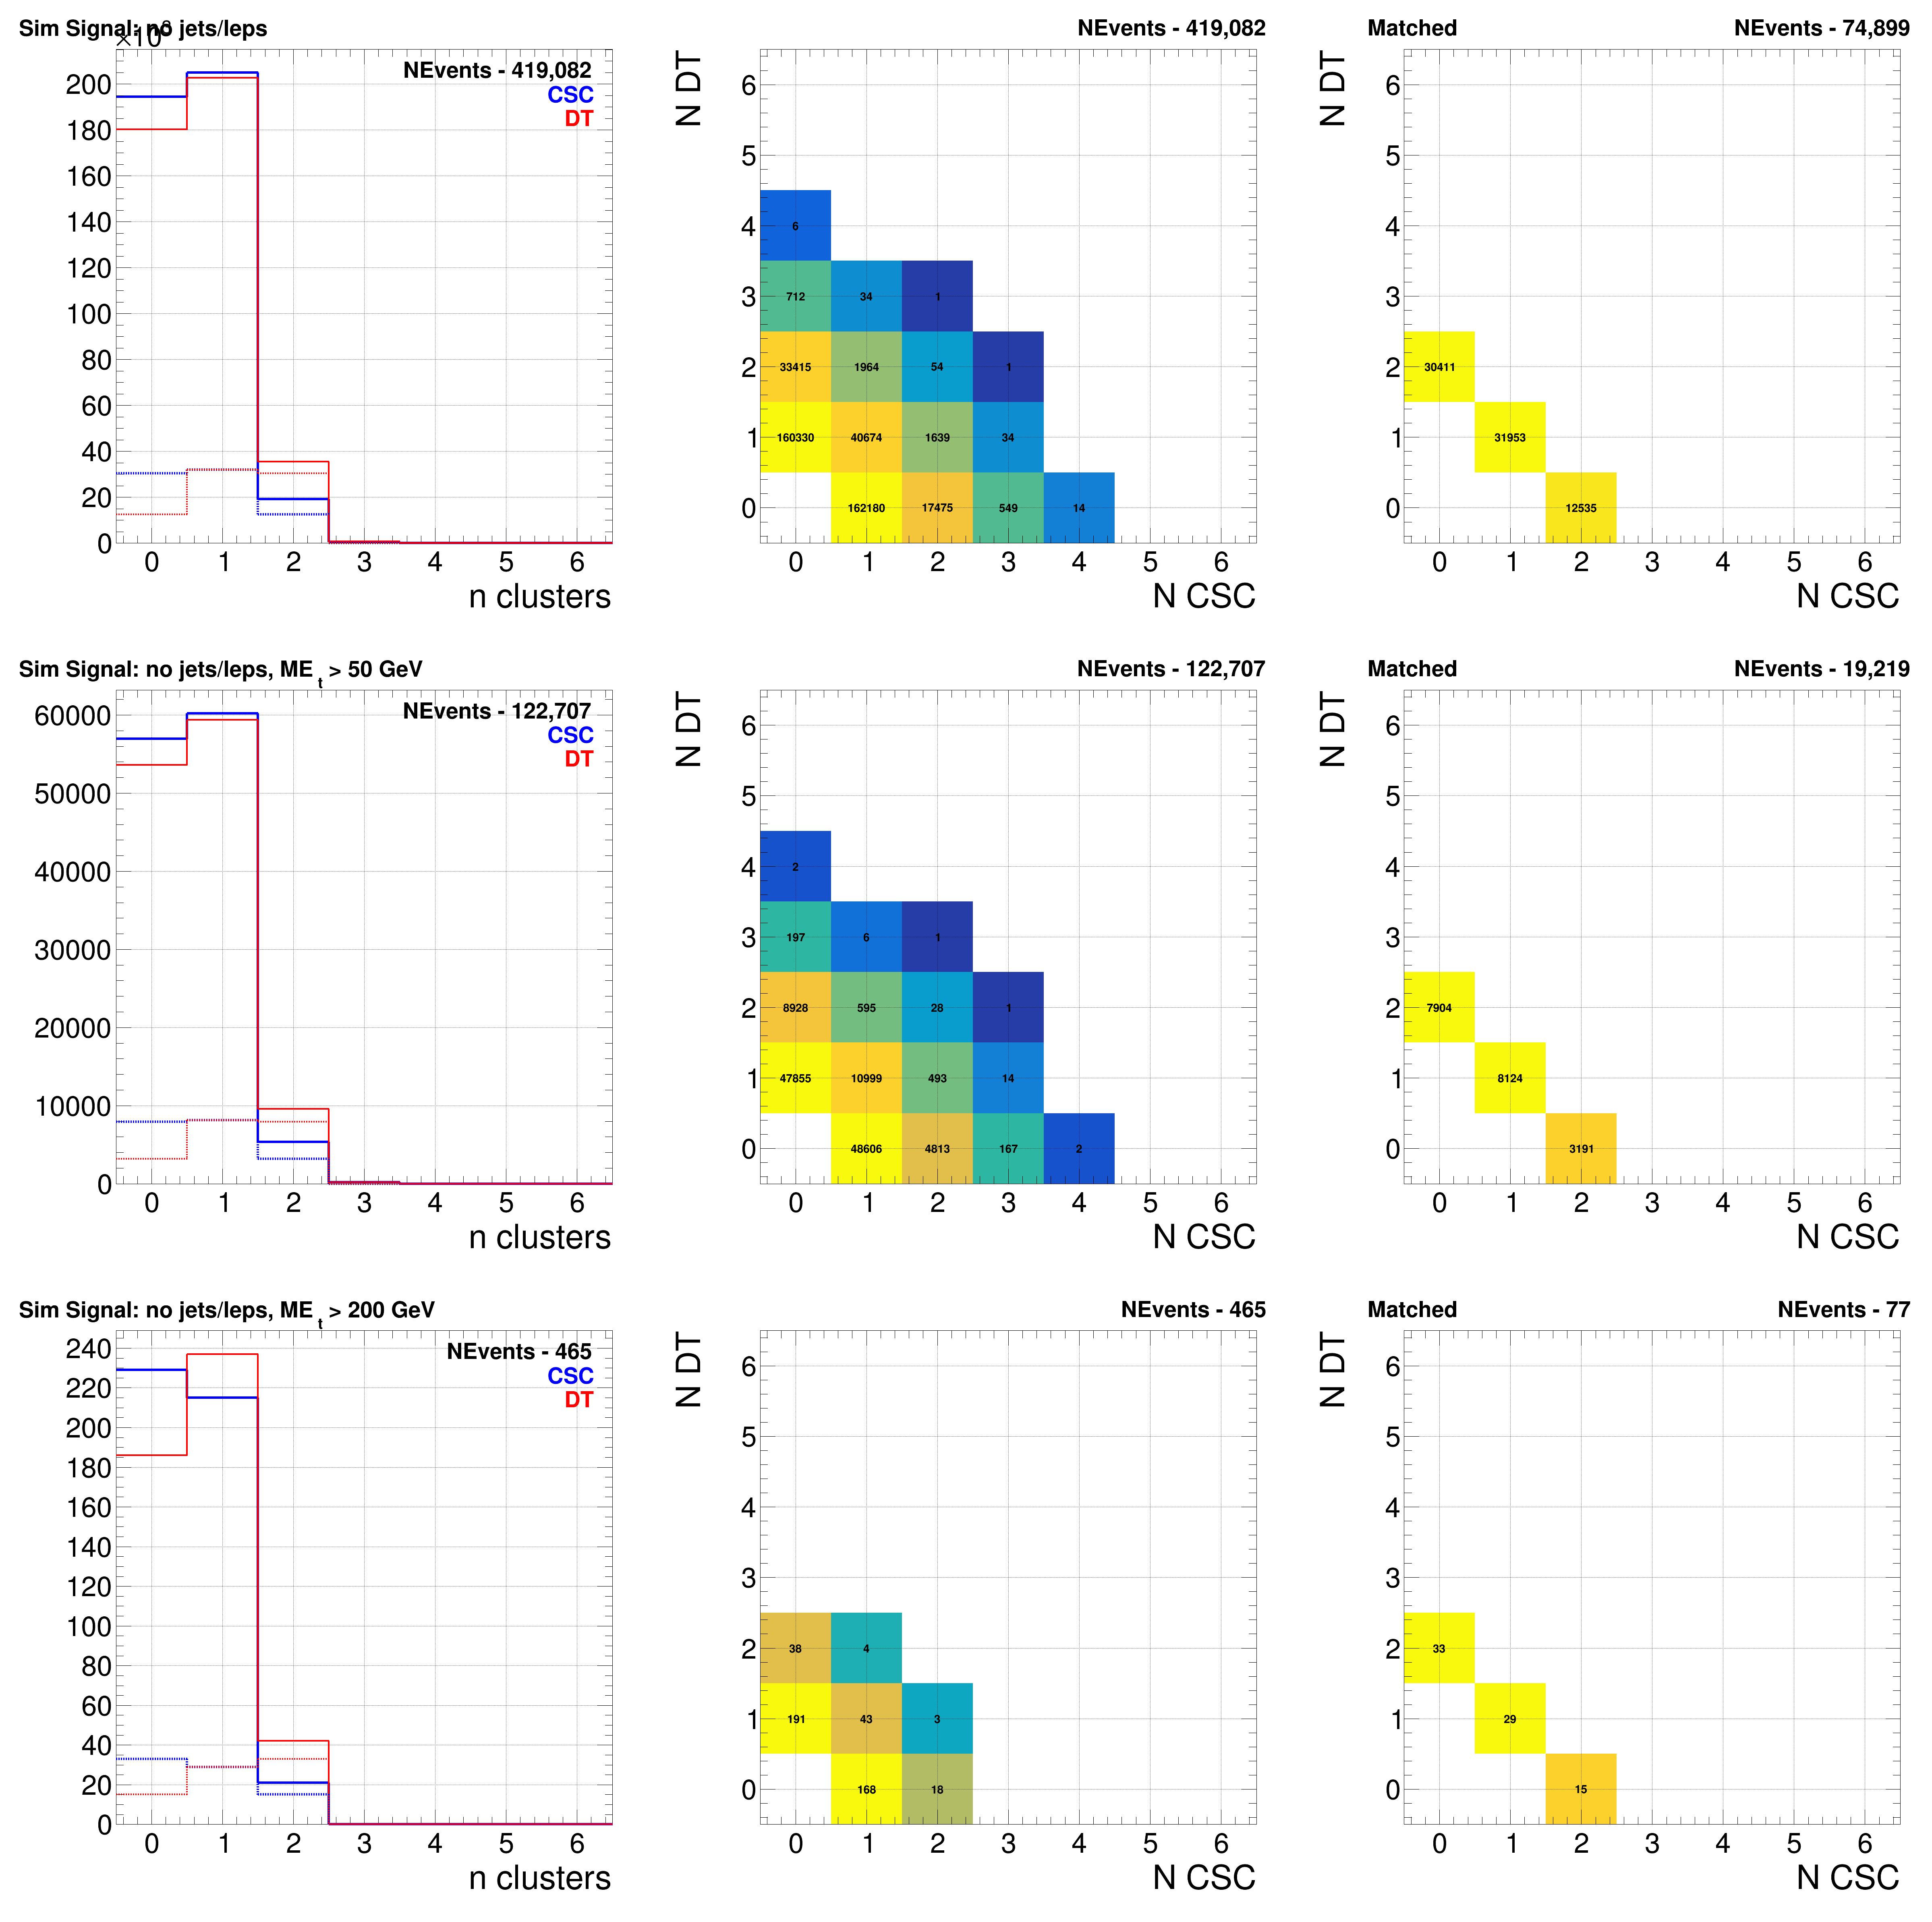

In [4]:
bins1D = (6, -0.5, 5.5)
bins2D = (6, -0.5, 5.5, 6, -0.5, 5.5)


c1 = rt.TCanvas('c1','c1',3*800,3*800); c1.Divide(3,3)
c1.Draw()

rdfA = rdf.Filter('nCscRechitClusters + nDtRechitClusters >= 2')
rdfM = apply_match_cut(rdfA).Filter('nCscRechitClusters + nDtRechitClusters >= 2')

tts = [
    [rdf, 'Sim Signal: no jets/leps'],
    [rdf50, 'Sim Signal: no jets/leps, ME_{t} > 50 GeV'],
    [rdf200, 'Sim Signal: no jets/leps, ME_{t} > 200 GeV'],
]
for irdf, (_rdf, tt)in enumerate(tts):
    _rdf = _rdf.Filter('nCscRechitClusters + nDtRechitClusters >= 1')#2')
    _rdf_matched = apply_match_cut(_rdf).Filter('nCscRechitClusters + nDtRechitClusters >= 1')#2')
    
    csc1D  = _rdf.Histo1D(('csc','N Clusters;n clusters',*bins1D),'nCscRechitClusters')
    cscM1D = _rdf_matched.Histo1D(('cscmat','N Clusters;n clusters',*bins1D),'nCscRechitClusters')
    
    dt1D   = _rdf.Histo1D(('dt','N Clusters;n clusters',*bins1D),'nDtRechitClusters')
    dtM1D  = _rdf_matched.Histo1D(('dtmat','N Clusters;n clusters',*bins1D),'nDtRechitClusters')
    
    all2D  = _rdf.Histo2D(('all','all;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')
    mat2D  = _rdf_matched.Histo2D(('mat','mat;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')

    hhs = [
        [csc1D, dt1D, cscM1D, dtM1D],
        all2D,
        mat2D,
    ]

    lat.SetTextAlign(33)
    lat.SetTextColor(rt.kBlack)
    for ih, hh in enumerate(hhs):
        c1.cd(irdf*len(hhs)+ ih + 1)
        if isinstance(hh, Iterable):
            ymax = max([h.GetMaximum()for h in hh])
            for h in hh:
                h.SetLineWidth(4)
                if 'csc' in h.GetName():
                    h.SetLineColor(rt.kBlue)
                    h.SetLineWidth(6)
                else:
                    h.SetLineColor(rt.kRed)
                if 'mat' in h.GetName():
                    h.SetLineStyle(2)
                h.SetMaximum(ymax*1.05)
                h.Draw('same')
                # h.DrawNormalized('same')
            
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(0.95, 0.93, f'NEvents - {_rdf.Count().GetValue():,.0f}')
            lat.SetTextColor(rt.kBlue)
            lat.DrawLatexNDC(0.95, 0.89, 'CSC')
            lat.SetTextColor(rt.kRed)
            lat.DrawLatexNDC(0.95, 0.85, 'DT')
        else:
            c1.cd(irdf*len(hhs)+ ih + 1).SetLogz()
            hh.Draw('coltext')
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(1, 1, f'NEvents - {hh.Integral():,.0f}')

            if 'mat' in hh.GetName():
                lat.SetTextAlign(13)
                lat.DrawLatexNDC(0.1, 1, 'Matched')


    lat.SetTextAlign(13)
    c1.cd(irdf*len(hhs)+ 1)
    # lat.SetTextColor(rt.kRed)
    lat.DrawLatexNDC(0,1, tt)

    gc.extend(hhs)

c1.Print(f'reports/weekly/{date}/n_clusters.png')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file reports/weekly/jan30/n_clusters_acceptance.png has been created


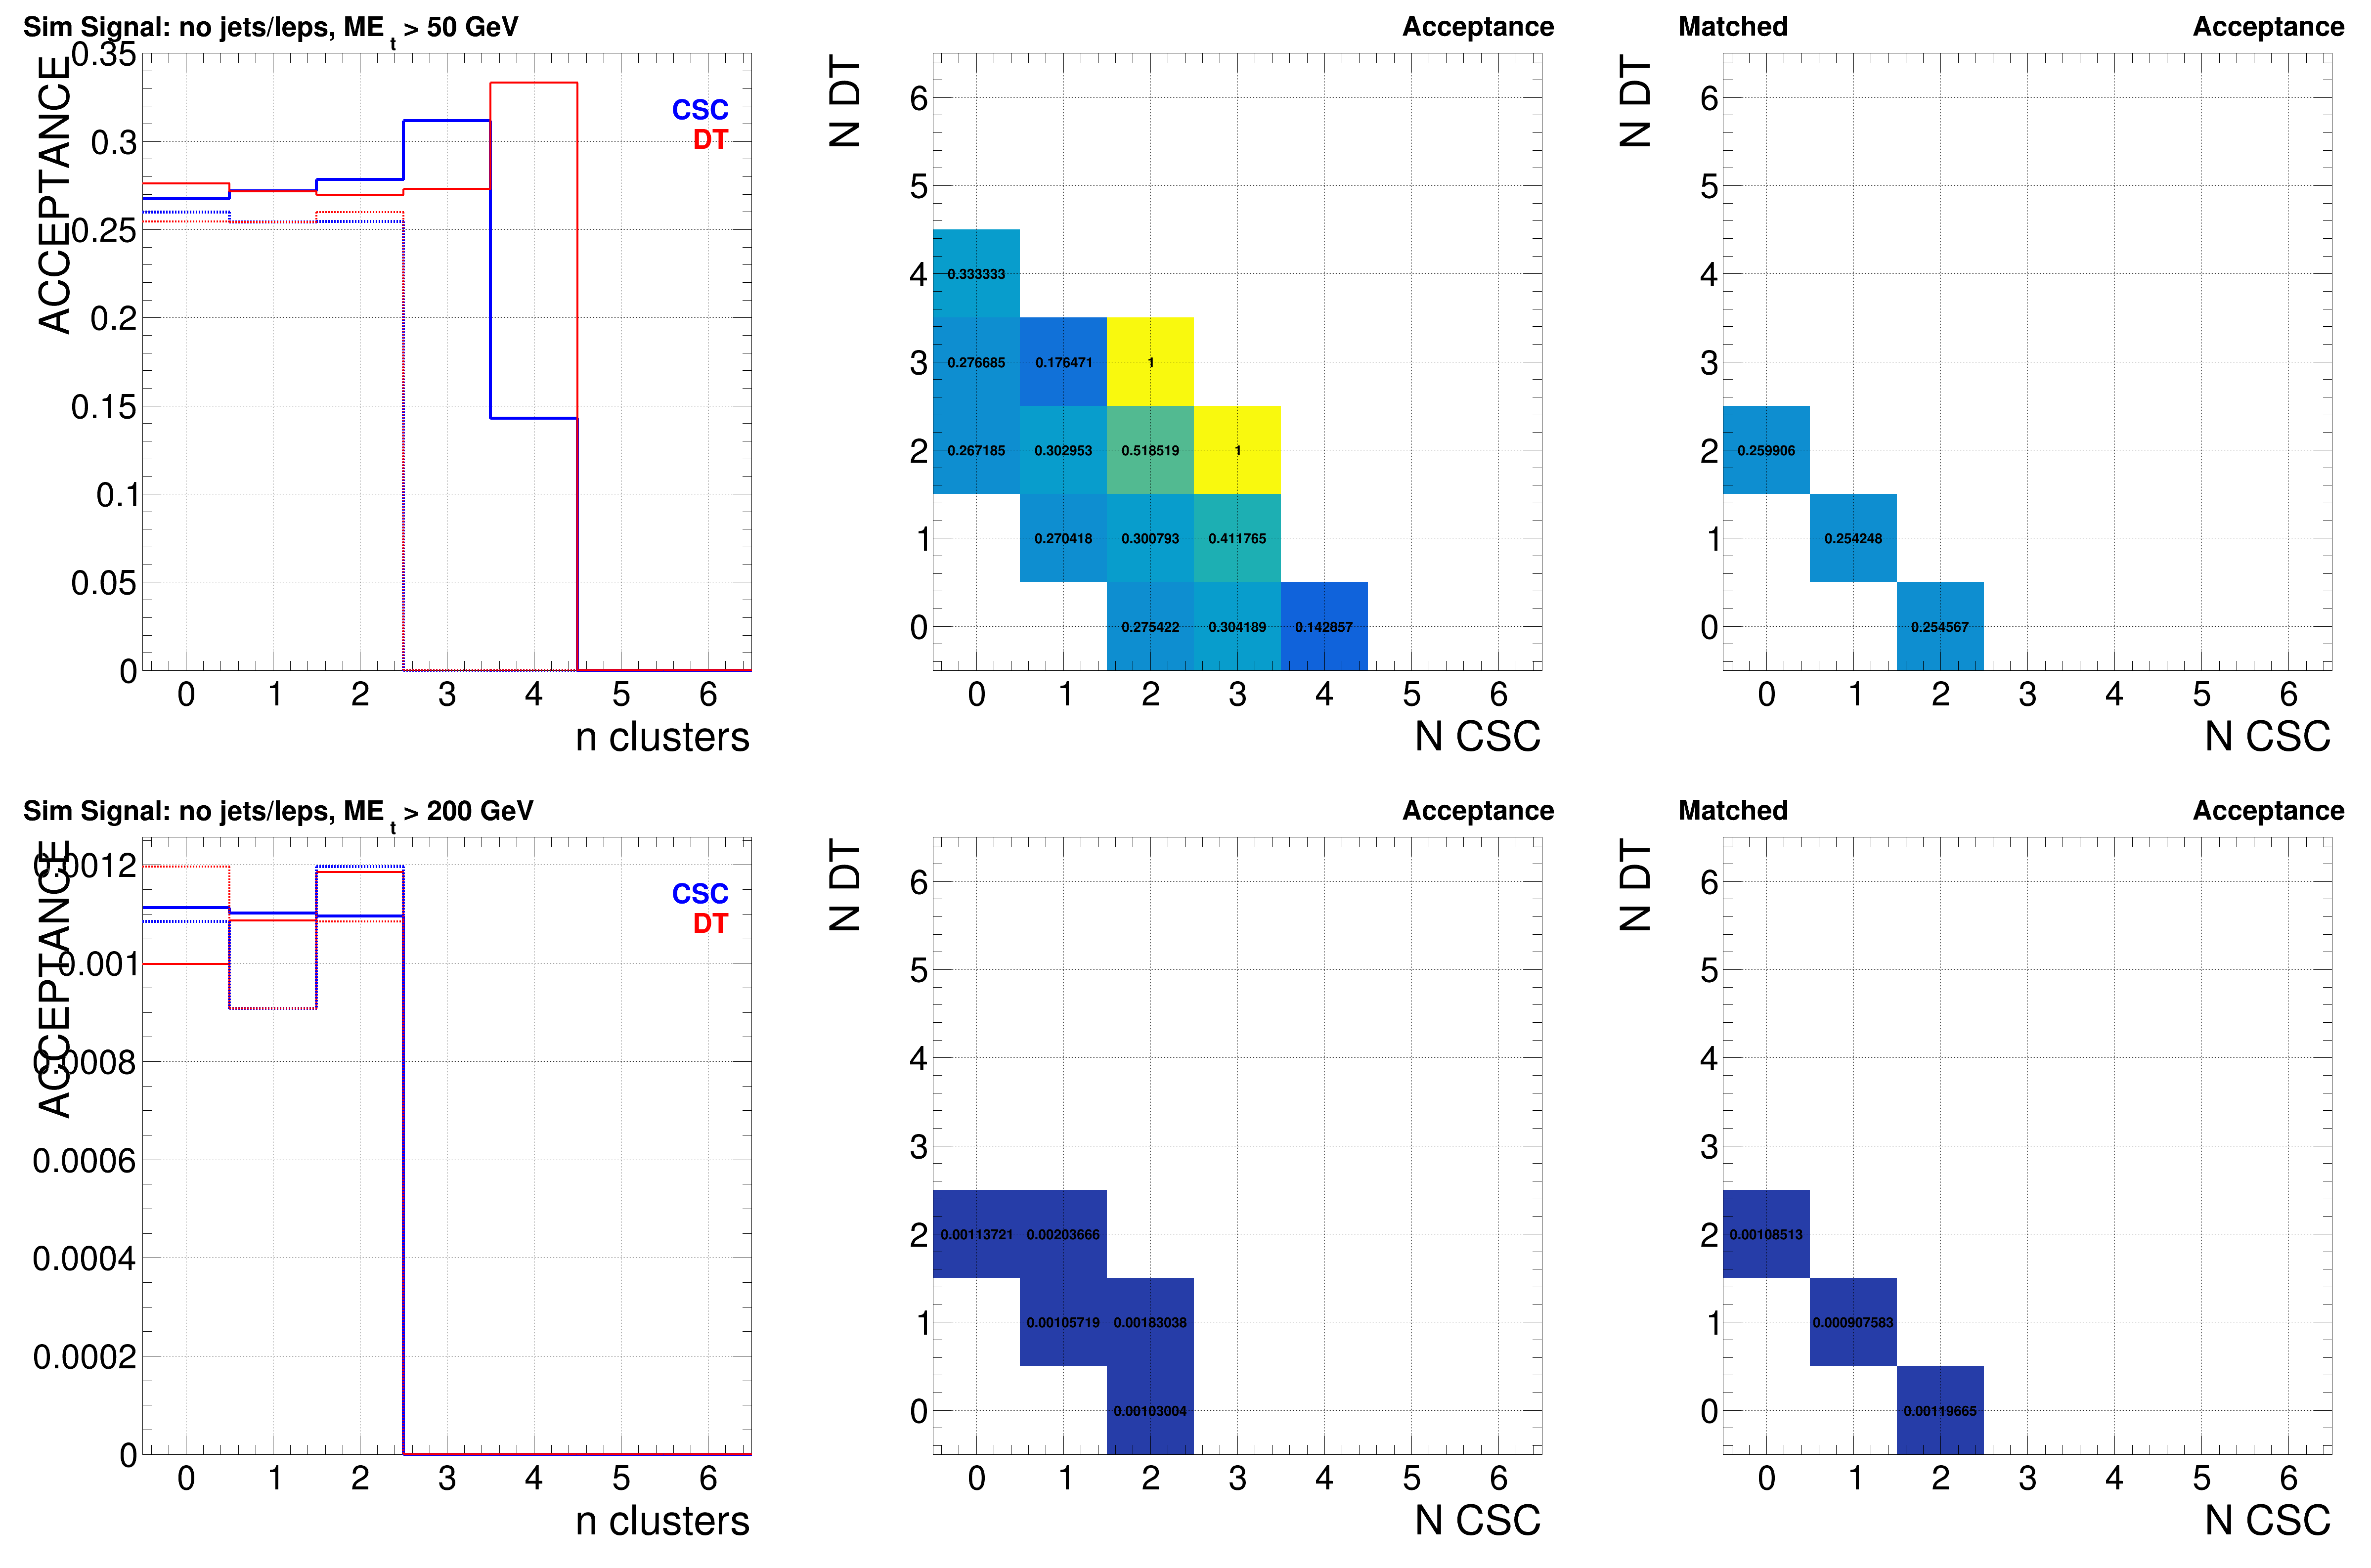

In [5]:
c1 = rt.TCanvas('c1','c1',3*800,2*800); c1.Divide(3,2)
c1.Draw()

rdfA = rdf.Filter('nCscRechitClusters + nDtRechitClusters >= 2')
rdfM = apply_match_cut(rdfA).Filter('nCscRechitClusters + nDtRechitClusters >= 2')

tts = [
    [rdf50, 'Sim Signal: no jets/leps, ME_{t} > 50 GeV'],
    [rdf200, 'Sim Signal: no jets/leps, ME_{t} > 200 GeV'],
]
for irdf, (_rdf, tt)in enumerate(tts):
    _rdf = _rdf.Filter('nCscRechitClusters + nDtRechitClusters >= 2')
    _rdf_matched = apply_match_cut(_rdf).Filter('nCscRechitClusters + nDtRechitClusters >= 2')
    
    csc1D  = _rdf.Histo1D(('csc','N Clusters;n clusters;ACCEPTANCE',*bins1D),'nCscRechitClusters')
    cscM1D = _rdf_matched.Histo1D(('cscmat','N Clusters;n clusters;ACCEPTANCE',*bins1D),'nCscRechitClusters')
    
    dt1D   = _rdf.Histo1D(('dt','N Clusters;n clusters',*bins1D),'nDtRechitClusters')
    dtM1D  = _rdf_matched.Histo1D(('dtmat','N Clusters;n clusters',*bins1D),'nDtRechitClusters')
    
    all2D  = _rdf.Histo2D(('all','all;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')
    mat2D  = _rdf_matched.Histo2D(('mat','mat;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')

    csc1D.Divide( rdfA.Histo1D(('csc','N Clusters;n clusters',*bins1D),'nCscRechitClusters').GetPtr())
    cscM1D.Divide(rdfM.Histo1D(('cscmat','N Clusters;n clusters',*bins1D),'nCscRechitClusters').GetPtr())
    
    dt1D.Divide(  rdfA.Histo1D(('dt','N Clusters;n clusters',*bins1D),'nDtRechitClusters').GetPtr())
    dtM1D.Divide( rdfM.Histo1D(('dtmat','N Clusters;n clusters',*bins1D),'nDtRechitClusters').GetPtr())

    all2D.Divide( rdfA.Histo2D(('all','all;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters').GetPtr())
    mat2D.Divide( rdfM.Histo2D(('mat','mat;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters').GetPtr())

    hhs = [
        [csc1D, dt1D, cscM1D, dtM1D],
        all2D,
        mat2D,
    ]

    lat.SetTextAlign(33)
    lat.SetTextColor(rt.kBlack)
    for ih, hh in enumerate(hhs):
        c1.cd(irdf*len(hhs)+ ih + 1)
        if isinstance(hh, Iterable):
            ymax = max([h.GetMaximum()for h in hh])
            for h in hh:
                h.SetLineWidth(4)
                if 'csc' in h.GetName():
                    h.SetLineColor(rt.kBlue)
                    h.SetLineWidth(6)
                else:
                    h.SetLineColor(rt.kRed)
                if 'mat' in h.GetName():
                    h.SetLineStyle(2)
                h.SetMaximum(ymax*1.05)
                h.Draw('same')
                # h.DrawNormalized('same')
            
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            # lat.DrawLatexNDC(0.95, 0.93, f'NEvents - {_rdf.Count().GetValue():,.0f}')
            lat.SetTextColor(rt.kBlue)
            lat.DrawLatexNDC(0.95, 0.89, 'CSC')
            lat.SetTextColor(rt.kRed)
            lat.DrawLatexNDC(0.95, 0.85, 'DT')
        else:
            c1.cd(irdf*len(hhs)+ ih + 1)#.SetLogz()
            hh.SetMinimum(0)
            hh.SetMaximum(1)
            # hh.SetMarkerColor(rt.kRed)
            hh.Draw('coltext')
            lat.SetTextAlign(33)
            lat.SetTextColor(rt.kBlack)
            lat.DrawLatexNDC(1, 1, 'Acceptance')

            if 'mat' in hh.GetName():
                lat.SetTextAlign(13)
                lat.DrawLatexNDC(0.1, 1, 'Matched')


    lat.SetTextAlign(13)
    c1.cd(irdf*len(hhs)+ 1)
    # lat.SetTextColor(rt.kRed)
    lat.DrawLatexNDC(0,1, tt)

    gc.extend(hhs)
c1.Print(f'reports/weekly/{date}/n_clusters_acceptance.png')


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


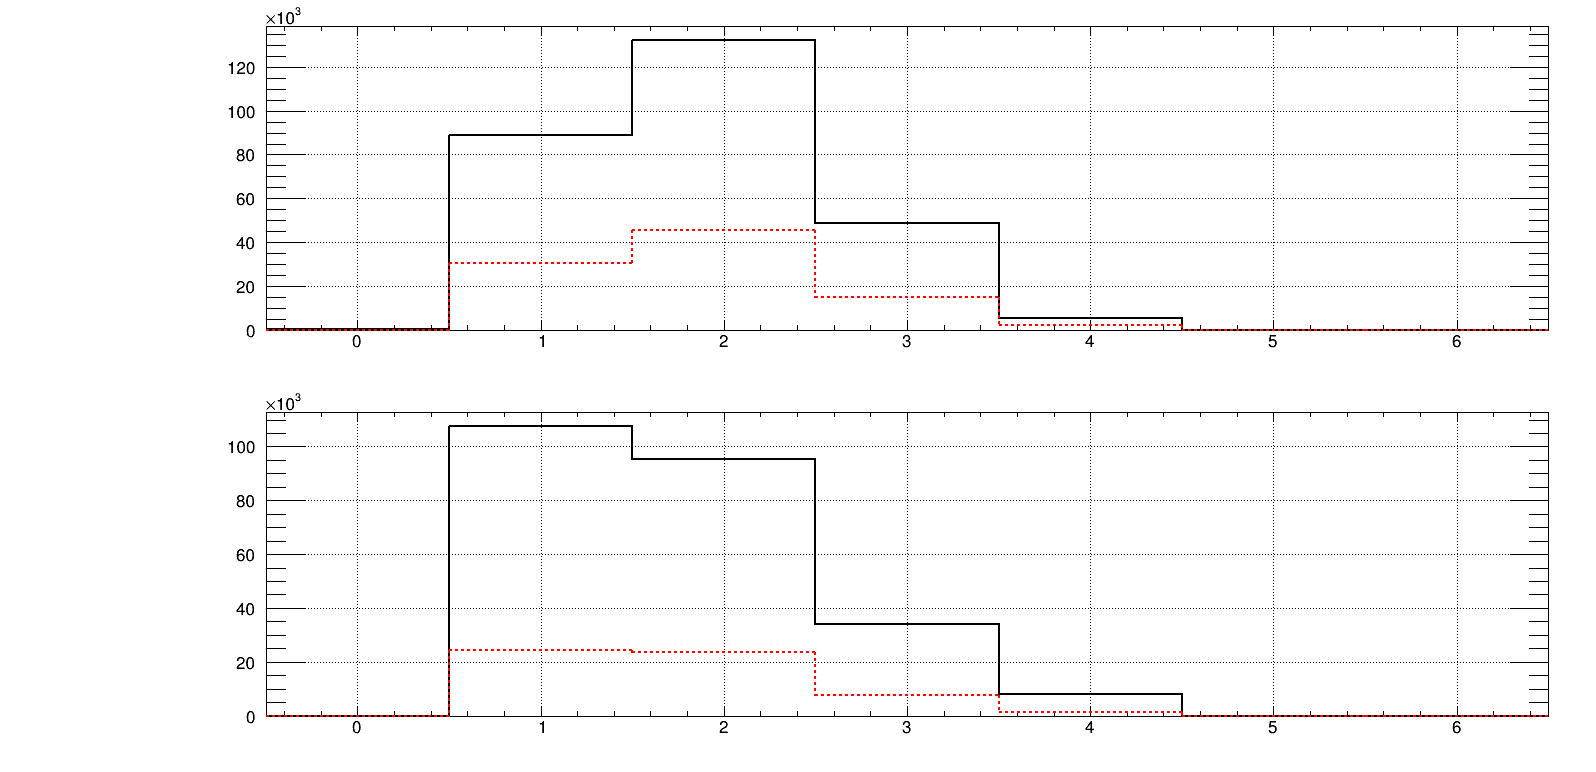

In [6]:
c1 = rt.TCanvas('c1','c1',1600,800)
c1.Divide(1,2)
c1.Draw()

for i, col in enumerate(('dtRechitClusterNStation10','cscRechitClusterNStation10')):
    c1.cd(i + 1)
    h1 = rdf.Histo1D(('',col,7,-0.5,6.5),col)
    h1.Draw('same')

    h2 = apply_match_cut(rdf).Histo1D(('',col,7,-0.5,6.5),col)
    h2.SetLineStyle(2)
    h2.SetLineColor(rt.kRed)
    h2.Draw('same')

    gc.extend([h1,h2])


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


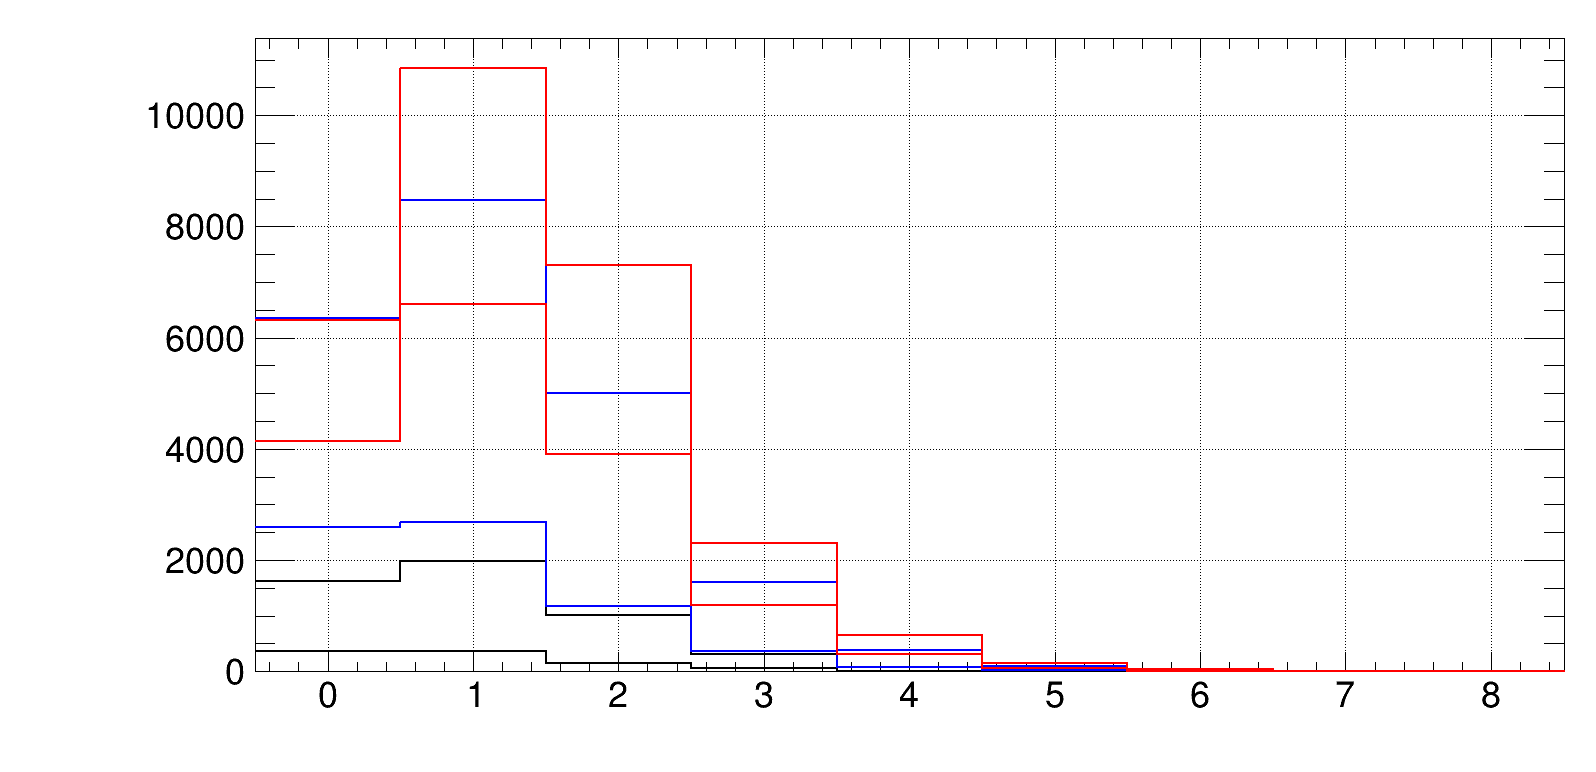

In [7]:
c1 = rt.TCanvas('c1','c1',1600,800)
c1.Draw()
c1.cd(1)

template = ('','',9,-0.5,8.5)

h1 = rdf_bkg.Filter('nCscRechitClusters == 2').Histo1D(template, 'nJets')
h2 = rdf_bkg.Filter('nCscRechitClusters == 1').Histo1D(template, 'nJets')
h3 = rdf_bkg.Filter('nCscRechitClusters == 0').Histo1D(template, 'nJets')
h4 = apply_match_cut(rdf_bkg).Filter('nCscRechitClusters == 2').Histo1D(template, 'nJets')
h5 = apply_match_cut(rdf_bkg).Filter('nCscRechitClusters == 1').Histo1D(template, 'nJets')
h6 = apply_match_cut(rdf_bkg).Filter('nCscRechitClusters == 0').Histo1D(template, 'nJets')
hhs = [h1, h2, h3, h4, h5, h6]

ymax = max([hh.GetMaximum() for hh in hhs])
for hh, cc in zip(hhs, [rt.kBlack, rt.kBlue, rt.kRed]*2):
    hh.SetMaximum(ymax * 1.05)
    hh.SetLineColor(cc)
    hh.Draw('same')
gc.extend(hhs)



In [8]:
import pandas as pd
from tqdm import tqdm


def convert_rdf_to_flat_pandas_df(input_rdf, double_data=False, has_label=False):
    # Cuts on data before training
        # No leptons
        # No jets (if doing cluster + cluster)
        # No jets matched to clusters (if doing jet + cluster)
        # Cluster in time and low spread
        # Nstation == 1?

    # rdf_out = input_rdf.Filter('(nJets == 0)&& (nLeptons == 0)')
    # rdf_out = apply_time_cut(rdf_out, col_type='csc')
    # rdf_out = apply_time_cut(rdf_out, col_type='dt')# TIME CUT ON DT IS BAD, DT TIME COL NOT FILLED

    print('Raw')
    input_rdf = input_rdf.Filter('nCscRechitClusters + nDtRechitClusters >= 2')
    print(f'\tnEvts: {input_rdf.Count().GetValue():,.0f}')
    print(f'\tnJets: {input_rdf.Sum("nJets").GetValue():,.0f}')
    print(f'\tnLeps: {input_rdf.Sum("nLeptons").GetValue():,.0f}')

    if has_label:
        print('If I apply match cut')
        trdf_out = apply_match_cut(input_rdf).Filter('nCscRechitClusters + nDtRechitClusters >= 2')
        print(f'\tnEvts: {trdf_out.Count().GetValue():,.0f}')
        print(f'\tnJets: {trdf_out.Sum("nJets").GetValue():,.0f}')
        print(f'\tnLeps: {trdf_out.Sum("nLeptons").GetValue():,.0f}')

    print('Applying 2 cluster cut')
    rdf_out = input_rdf.Filter('nCscRechitClusters + nDtRechitClusters == 2')
    print(f'\tnEvts: {rdf_out.Count().GetValue():,.0f}')
    print(f'\tnJets: {rdf_out.Sum("nJets").GetValue():,.0f}')
    print(f'\tnLeps: {rdf_out.Sum("nLeptons").GetValue():,.0f}')

    print('If I remove all events that have jets or leptons')
    trdf_out = rdf_out.Filter('(nJets == 0)&& (nLeptons == 0)')
    print(f'\tnEvts: {trdf_out.Count().GetValue():,.0f}')
    print(f'\tnJets: {trdf_out.Sum("nJets").GetValue():,.0f}')
    print(f'\tnLeps: {trdf_out.Sum("nLeptons").GetValue():,.0f}')

    # Info cols (DONT TRAIN ON):
        # runNum
        # evtNum

    # columns:
        # no -> nCscRechitClusters
        # no -> nDtRechitClusters
        # MET
        # MET Phi
    # double these for each cluster
        # isCSC
        # isLLP
        # NStation10
        # AvgStation10
        # ClusterPhi
        # ClusterEta
        # ClusterMet_dPhi
        # ClusterSize
    # if doing jet + cluster include
        # jetE
        # jetPt
        # jetPhi
        # jetEta

    # target
        # LLP match
        # LLP match E or Pt

    cluster_vals = ['NStation10', 'AvgStation10', 'Phi', 'Eta', 'Met_dPhi', 'Size']
    if has_label:
        cluster_vals.append('_match_gLLP')
    cluster_vals = [f'{x}RechitCluster{v}' for v in cluster_vals for x in ('dt', 'csc')]
    event_vals  = ['runNum', 'evtNum', 'met', 'metPhi', 'nJets', 'nLeptons', 'jetE', 'jetPt', 'jetEta', 'jetPhi']
    cols = event_vals + cluster_vals
    from_rdf = rdf_out.AsNumpy(cols)

    print(f'{len(from_rdf["runNum"]):,}')

    dd_out = {
        'runNum' : [],
        'evtNum' : [],
        'met' : [],
        'metPhi' : [],
        'dR' : [],
        'nJets' : [],
        'jetE' : [],
        'jetPt' : [],
        'jetEta': [],
        'jetPhi' : [],
        'isCsc0' : [],
        'nStat0' : [],
        'avgStat0' : [],
        'phi0' : [],
        'Met_dPhi0' : [],
        'eta0' : [],
        'size0' : [],
        'isCsc1' : [],
        'nStat1' : [],
        'avgStat1' : [],
        'phi1' : [],
        'Met_dPhi1' : [],
        'eta1' : [],
        'size1' : [],
    }
    if has_label:
        dd_out['isLLP0'] = []
        dd_out['isLLP1'] = []

    for iev in tqdm(range(len(from_rdf['runNum']))):
        for k in from_rdf:
            if isinstance(from_rdf[k][0], Iterable):
                from_rdf[k][iev] = [float(x)for x in from_rdf[k][iev]]

        if len(from_rdf['cscRechitClusterSize'][iev])== 2:
            det0, idx0 = 'csc', 0
            det1, idx1 = 'csc', 1
        elif len(from_rdf['cscRechitClusterSize'][iev])== 1:
            det0, idx0 = 'csc', 0
            det1, idx1 = 'dt', 0
        else:
            det0, idx0 = 'dt', 0
            det1, idx1 = 'dt', 1
        det0, det1 = det0+'RechitCluster', det1+'RechitCluster'

        dd_out['runNum'].append( from_rdf['runNum'][iev] )
        dd_out['evtNum'].append( from_rdf['evtNum'][iev] )
        dd_out['met'].append( from_rdf['met'][iev] )
        dd_out['metPhi'].append( from_rdf['metPhi'][iev] )
        dd_out['nJets'].append( from_rdf['nJets'][iev] )
        if from_rdf['nJets'][iev] > 0:
            jet_idx = np.argmax(from_rdf['jetPt'][iev])
            dd_out['jetE'].append( from_rdf['jetE'][iev][jet_idx] )
            dd_out['jetPt'].append( from_rdf['jetPt'][iev][jet_idx] )
            dd_out['jetEta'].append( from_rdf['jetEta'][iev][jet_idx] )
            dd_out['jetPhi'].append( from_rdf['jetPhi'][iev][jet_idx] )
        else:
            dd_out['jetE'].append( 0 )
            dd_out['jetPt'].append( 0 )
            dd_out['jetEta'].append( 0 )
            dd_out['jetPhi'].append( 0 )

        dd_out['isCsc0'].append( int('csc' in det0))
        dd_out['nStat0'].append( from_rdf[det0+'NStation10'][iev][idx0] )
        dd_out['avgStat0'].append( from_rdf[det0+'AvgStation10'][iev][idx0] )
        dd_out['phi0'].append( from_rdf[det0+'Phi'][iev][idx0] )
        dd_out['Met_dPhi0'].append( from_rdf[det0+'Met_dPhi'][iev][idx0] )
        dd_out['eta0'].append( from_rdf[det0+'Eta'][iev][idx0] )
        dd_out['size0'].append( from_rdf[det0+'Size'][iev][idx0] )

        dd_out['isCsc1'].append( int('csc' in det1))
        dd_out['nStat1'].append( from_rdf[det1+'NStation10'][iev][idx1] )
        dd_out['avgStat1'].append( from_rdf[det1+'AvgStation10'][iev][idx1] )
        dd_out['phi1'].append( from_rdf[det1+'Phi'][iev][idx1] )
        dd_out['Met_dPhi1'].append( from_rdf[det1+'Met_dPhi'][iev][idx1] )
        dd_out['eta1'].append( from_rdf[det1+'Eta'][iev][idx1] )
        dd_out['size1'].append( from_rdf[det1+'Size'][iev][idx1] )
        if has_label:
            dd_out['isLLP0'].append( from_rdf[det0+'_match_gLLP'][iev][idx0] )
            dd_out['isLLP1'].append( from_rdf[det1+'_match_gLLP'][iev][idx1] )

        # Also include data where 0->1 and 1->0
        if double_data:
            dd_out['runNum'].append( from_rdf['runNum'][iev] )
            dd_out['evtNum'].append( from_rdf['evtNum'][iev] )
            dd_out['met'].append( from_rdf['met'][iev] )
            dd_out['metPhi'].append( from_rdf['metPhi'][iev] )
            dd_out['nJets'].append( from_rdf['nJets'][iev] )
            if from_rdf['nJets'][iev] > 0:
                jet_idx = np.argmax(from_rdf['jetPt'][iev])
                dd_out['jetE'].append( from_rdf['jetE'][iev][jet_idx] )
                dd_out['jetPt'].append( from_rdf['jetPt'][iev][jet_idx] )
                dd_out['jetEta'].append( from_rdf['jetEta'][iev][jet_idx] )
                dd_out['jetPhi'].append( from_rdf['jetPhi'][iev][jet_idx] )
            else:
                dd_out['jetE'].append( 0 )
                dd_out['jetPt'].append( 0 )
                dd_out['jetEta'].append( 0 )
                dd_out['jetPhi'].append( 0 )

            dd_out['isCsc1'].append( int('csc' in det0))
            dd_out['nStat1'].append( from_rdf[det0+'NStation10'][iev][idx0] )
            dd_out['avgStat1'].append( from_rdf[det0+'AvgStation10'][iev][idx0] )
            dd_out['phi1'].append( from_rdf[det0+'Phi'][iev][idx0] )
            dd_out['Met_dPhi1'].append( from_rdf[det0+'Met_dPhi'][iev][idx0] )
            dd_out['eta1'].append( from_rdf[det0+'Eta'][iev][idx0] )
            dd_out['size1'].append( from_rdf[det0+'Size'][iev][idx0] )

            dd_out['isCsc0'].append( int('csc' in det1))
            dd_out['nStat0'].append( from_rdf[det1+'NStation10'][iev][idx1] )
            dd_out['avgStat0'].append( from_rdf[det1+'AvgStation10'][iev][idx1] )
            dd_out['phi0'].append( from_rdf[det1+'Phi'][iev][idx1] )
            dd_out['Met_dPhi0'].append( from_rdf[det1+'Met_dPhi'][iev][idx1] )
            dd_out['eta0'].append( from_rdf[det1+'Eta'][iev][idx1] )
            dd_out['size0'].append( from_rdf[det1+'Size'][iev][idx1] )
            if has_label:
                dd_out['isLLP1'].append( from_rdf[det0+'_match_gLLP'][iev][idx0] )
                dd_out['isLLP0'].append( from_rdf[det1+'_match_gLLP'][iev][idx1] )


    for k, v in dd_out.items():
        dd_out[k] = np.asarray(v)
    dd_out['dR'] = np.sqrt((dd_out['eta0']-dd_out['eta1'])**2 + (dd_out['phi0']-dd_out['phi1'])**2)
    df_out = pd.DataFrame(dd_out)
    # (df_out['isLLP0'] + df_out['isLLP1']).hist()
    # if df_out.isna().sum().sum():
    #     print(f'Filling {df_out.isna().sum().sum():,} NaN with mean')
    #     df_out = df_out.fillna(df_out.mean())
    #     # df_out.dropna(inplace=True)

    return rdf_out, df_out

rdf_out, df_out = convert_rdf_to_flat_pandas_df(rdf_raw, double_data=True, has_label=True)
df_out

Raw
	nEvts: 254,585
	nJets: 244,399
	nLeps: 3,200
If I apply match cut
	nEvts: 173,708
	nJets: 147,615
	nLeps: 2,403
Applying 2 cluster cut
	nEvts: 240,429
	nJets: 229,684
	nLeps: 2,985
If I remove all events that have jets or leptons
	nEvts: 90,263
	nJets: 0
	nLeps: 0
240,429


100%|██████████| 240429/240429 [00:09<00:00, 24850.64it/s]


,runNum,evtNum,met,metPhi,dR,nJets,jetE,jetPt,jetEta,jetPhi,...,size0,isCsc1,nStat1,avgStat1,phi1,Met_dPhi1,eta1,size1,isLLP0,isLLP1
0,1,50668174,58.982986,0.543431,3.463304,1,50.365688,41.793827,-0.616465,-2.164227,...,191.0,0,2.0,1.500000,-2.175096,-2.718526,-0.613722,36.0,1.0,1.0
1,1,50668174,58.982986,0.543431,3.463304,1,50.365688,41.793827,-0.616465,-2.164227,...,36.0,0,3.0,1.382199,1.233574,0.690143,-0.000988,191.0,1.0,1.0
2,1,50668188,29.881088,3.082173,0.824910,0,0.000000,0.000000,0.000000,0.000000,...,322.0,1,1.0,3.000000,2.074341,-1.007832,1.233959,154.0,1.0,0.0
3,1,50668188,29.881088,3.082173,0.824910,0,0.000000,0.000000,0.000000,0.000000,...,154.0,1,2.0,3.515528,2.745135,-0.337039,1.714076,322.0,0.0,1.0
4,1,50668209,25.742691,0.039041,1.366300,3,168.818771,46.529594,-1.960870,-2.325557,...,793.0,1,1.0,4.000000,0.558605,0.519564,2.111495,50.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480853,1,12380498,40.625114,0.368875,2.701330,2,72.048790,62.196194,0.544751,-3.073367,...,32.0,0,2.0,1.397661,-0.284058,-0.652933,0.543888,171.0,1.0,1.0
480854,1,12380508,12.045488,0.806060,2.359091,2,63.950943,50.065689,0.719602,-0.507147,...,450.0,0,1.0,1.000000,-0.475588,-1.281648,0.578217,62.0,1.0,1.0
480855,1,12380508,12.045488,0.806060,2.359091,2,63.950943,50.065689,0.719602,-0.507147,...,62.0,1,2.0,3.184444,1.289922,0.483862,2.142916,450.0,1.0,1.0
480856,1,12380527,43.166950,0.572430,3.869567,0,0.000000,0.000000,0.000000,0.000000,...,103.0,0,2.0,1.235294,-2.088364,-2.660794,1.004367,51.0,1.0,1.0


In [9]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.linear_model import SGDOneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_feats = [
    'met',
    'metPhi',
    'nJets',
    'jetE',
    'jetPt',
    'jetEta',
    'jetPhi',
    'nStat0',
    'avgStat0',
    'phi0',
    'Met_dPhi0',
    'eta0',
    'size0',
    'nStat1',
    'avgStat1',
    'phi1',
    'Met_dPhi1',
    'eta1',
    'size1',
    'dR',
]

cat_feats = [
    'isCsc0',
    'isCsc1',
]

train_cols = num_feats + cat_feats


idx_trn = df_out['evtNum'] < df_out['evtNum'].quantile(0.6)
idx_val = (df_out['evtNum'].quantile(0.6) <= df_out['evtNum']) & (df_out['evtNum'] < df_out['evtNum'].quantile(0.8))
idx_tst = df_out['evtNum'].quantile(0.8) <= df_out['evtNum']

X_trn = df_out[idx_trn][train_cols]
X_val = df_out[idx_val][train_cols]
X_tst = df_out[idx_tst][train_cols]

y_trn = ( df_out[idx_trn]['isLLP0'] + df_out[idx_trn]['isLLP1'] ) == 2
y_val = ( df_out[idx_val]['isLLP0'] + df_out[idx_val]['isLLP1'] ) == 2
y_tst = ( df_out[idx_tst]['isLLP0'] + df_out[idx_tst]['isLLP1'] ) == 2


# X, y  = df_out[train_cols], ((df_out['isLLP0']==1)& (df_out['isLLP1']==1))
# X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.6, random_state=0)

print(X_trn.shape, X_val.shape, X_tst.shape, sum(y_trn)/len(y_trn))#, sum(y_tst)/len(y_tst))

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])
pipe = Pipeline([
    ('preproccesor', ColumnTransformer([
        ('num_pipe', num_pipe, num_feats),
        ('encoder', OrdinalEncoder(), cat_feats),
    ], remainder='drop')),
    ('gbc', GradientBoostingClassifier(n_estimators=10)),
    # ('lof', LocalOutlierFactor(novelty=True, n_jobs=16)),
    # ('svm', OneClassSVM(verbose=999)),
    # ('isf', IsolationForest()),
])

print('Fitting GBC')
pipe.fit(X_trn, y_trn)

X_trn_true = X_trn[y_trn]
# print('Fitting LOF')
# pipe.fit(X_trn_true)
# print('Fitting OneClassSVM')
# pipe.fit(X_trn_true)
# print('Fitting IsolationForest')
# pipe.fit(X_trn_true)


(288514, 22) (96172, 22) (96172, 22) 0.6962019174112868
Fitting GBC


In [10]:
if 'gbc' in pipe.named_steps:
    importances = pipe.named_steps['gbc'].feature_importances_
    idxs = np.argsort(importances)[::-1]
    for name, weight in zip(np.array(train_cols)[idxs], importances[idxs]):
        print(f'{name:>10} - {100*weight:2.2f}')


        dR - 27.95
     size1 - 24.10
     size0 - 22.89
    isCsc0 - 5.59
    isCsc1 - 5.15
     jetPt - 4.25
      eta1 - 4.16
      eta0 - 3.01
       met - 2.89
    nStat1 - 0.00
  avgStat1 - 0.00
      phi1 - 0.00
      phi0 - 0.00
  avgStat0 - 0.00
    nStat0 - 0.00
    jetPhi - 0.00
    jetEta - 0.00
 Met_dPhi1 - 0.00
      jetE - 0.00
     nJets - 0.00
    metPhi - 0.00
 Met_dPhi0 - 0.00


ROC AUC: 0.885
+---------------+---------------+---------------+---------------+
|   Precision   |    Recall     |   Accuracy    |   Threshold   |
+---------------+---------------+---------------+---------------+
|     0.916     |     0.743     |     0.774     |     0.840     |
|     0.950     |     0.575     |     0.683     |     0.943     |
|     0.975     |     0.436     |     0.599     |     1.437     |
|     0.992     |     0.324     |     0.528     |     1.583     |
+---------------+---------------+---------------+---------------+

Setting goal precision to 95.0% (score>0.9428)
   % kept: 0.4212
  ROC AUC: 0.7530
 Accuracy: 0.6831
Precision: 0.9503
   Recall: 0.5749

   % kept: 0.4211
  ROC AUC: 0.7507
 Accuracy: 0.6811
Precision: 0.9481
   Recall: 0.5734



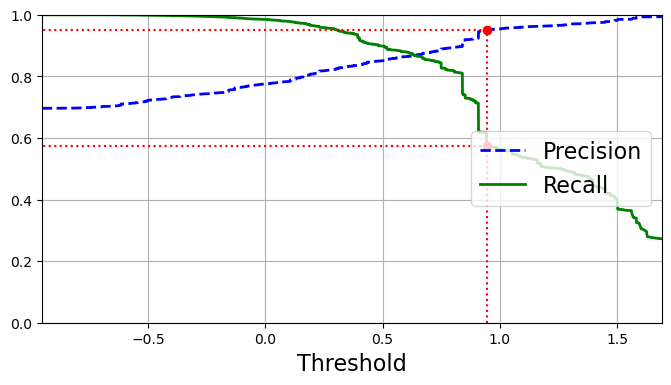

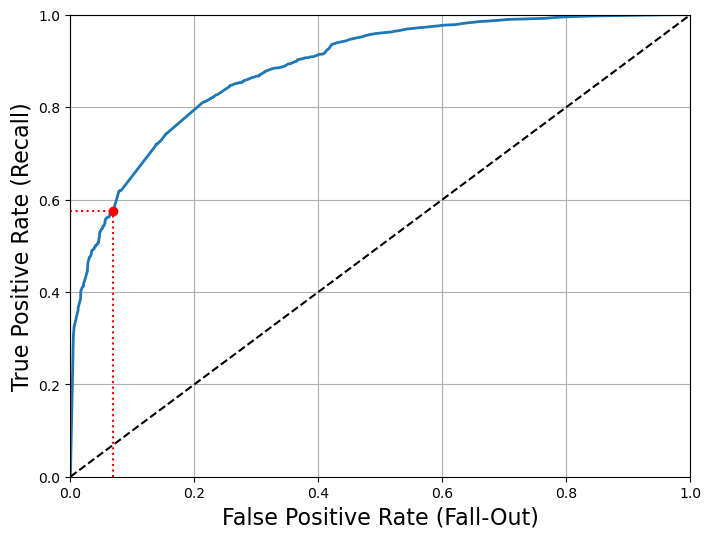

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# xx, yy = X_val, y_val
xx, yy = X_trn, y_trn
scores = pipe.decision_function(xx)

precisions, recalls, thresholds_prc = precision_recall_curve(yy, scores)
fprs, tprs, thresholds_roc = roc_curve(yy, scores)
print(f'ROC AUC: {roc_auc_score(yy,scores):.3f}')

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([min(thresholds), max(thresholds), 0, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)



print(4*('+'+15*'-')+'+')
print(f'|{"Precision":^15}|{"Recall":^15}|{"Accuracy":^15}|{"Threshold":^15}|')
print(4*('+'+15*'-')+'+')
for min_precision in (0.9, 0.95, 0.975, 0.99):
    thresh = thresholds_prc[np.argmax(precisions>=min_precision)]
    pp = scores>thresh
    pre = precision_score(yy, pp)
    rec = recall_score(yy, pp)
    acc = accuracy_score(yy, pp)
    print(f'|{pre:^15.3f}|{rec:^15.3f}|{acc:^15.3f}|{thresh:^15.3f}|')
print(4*('+'+15*'-')+'+')
print('')


###
goal_precision = 0.95
thresh = thresholds_prc[np.argmax(precisions >= goal_precision)]
print(f'Setting goal precision to {goal_precision*100:.1f}% (score>{thresh:.4f})')
###

####
goal_recall = recalls[np.argmax(precisions >= goal_precision)]
goal_fpr = fprs[np.argmax(tprs >= goal_recall)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds_prc)
plt.plot([thresh, thresh], [0., goal_precision], "r:")
plt.plot([-50000, thresh], [goal_precision, goal_precision], "r:")
plt.plot([-50000, thresh], [goal_recall, goal_recall], "r:")
plt.plot([thresh], [goal_precision], "ro")
plt.plot([thresh], [goal_recall], "ro")


plt.figure(figsize=(8, 6))
plot_roc_curve(fprs, tprs)
plt.plot([goal_fpr, goal_fpr], [0., goal_recall], "r:")
plt.plot([0.0, goal_fpr], [goal_recall, goal_recall], "r:")
plt.plot([goal_fpr], [goal_recall], "ro")
#####


for xx, yy in ((X_trn, y_trn), (X_val, y_val)):
    pp = pipe.decision_function(xx)>thresh
    print(f'   % kept: {np.mean(pp):.4f}')
    print(f'  ROC AUC: {roc_auc_score(yy, pp):.4f}')
    print(f' Accuracy: {accuracy_score(yy, pp):.4f}')
    print(f'Precision: {precision_score(yy, pp):.4f}')
    print(f'   Recall: {recall_score(yy, pp):.4f}')
    print('')

In [12]:
# fpath_run3 = 'data/raw/ggH_HToSSTobbbb_MH-125_MS-15_ctau-1000_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'
# rdf_run3_raw = rt.RDataFrame(tree_name, fpath_run3)
# rdf_run3_out, df_run3_out = convert_rdf_to_flat_pandas_df(rdf_run3_raw, has_label=True)

fpath_run3 = 'data/raw/DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v2_goodLumi.root'
rdf_run3_raw = rt.RDataFrame(tree_name, fpath_run3).Filter('nCscRechitClusters + nDtRechitClusters == 2')
rdf_run3_out, df_run3_out = convert_rdf_to_flat_pandas_df(rdf_run3_raw, has_label=False)


# rdf_run3_raw = rdf_sig
X_run3 = df_run3_out[train_cols]

scores_run3 = pipe.decision_function(df_run3_out)
y_pred_run3 = scores_run3 > thresh

if 'isLLP0' in df_run3_out:
    y_run3 = (df_run3_out['isLLP0']==1) & (df_run3_out['isLLP1']==1)
    print(f'   % kept: {np.mean(y_pred_run3):.4f} (expected {np.mean(y_run3):.4f})')
    print(f'  ROC AUC: {roc_auc_score(y_run3, y_pred_run3):.4f}')
    print(f' Accuracy: {accuracy_score(y_run3, y_pred_run3):.4f}')
    print(f'Precision: {precision_score(y_run3, y_pred_run3):.4f}')
    print(f'   Recall: {recall_score(y_run3, y_pred_run3):.4f}')

df_run3_out


Raw
	nEvts: 1,585,758
	nJets: 0
	nLeps: 17,678
Applying 2 cluster cut
	nEvts: 1,585,758
	nJets: 0
	nLeps: 17,678
If I remove all events that have jets or leptons
	nEvts: 1,569,164
	nJets: 0
	nLeps: 0
1,585,758


100%|██████████| 1585758/1585758 [00:41<00:00, 37841.36it/s]


,runNum,evtNum,met,metPhi,dR,nJets,jetE,jetPt,jetEta,jetPhi,...,Met_dPhi0,eta0,size0,isCsc1,nStat1,avgStat1,phi1,Met_dPhi1,eta1,size1
0,360826,131691806,43.610229,-1.248840,4.735351,0,0,0,0,0,...,-1.254978,1.267230,216.0,1,1.0,1.000000,2.113511,-2.920834,2.317857,56.0
1,360826,133016534,50.840057,-1.083343,2.351807,0,0,0,0,0,...,2.740519,-1.455608,51.0,0,1.0,2.000000,1.593739,2.677082,0.895343,95.0
2,360826,133364903,19.404644,-2.235774,4.449724,0,0,0,0,0,...,-0.127185,1.426691,205.0,1,3.0,2.795455,2.039589,-2.007822,2.072924,53.0
3,360826,131877018,49.623920,-2.501387,0.918706,0,0,0,0,0,...,3.006629,1.427831,194.0,1,2.0,1.372881,0.748330,-3.033468,2.313793,65.0
4,360826,132513564,39.703747,-3.088493,3.466214,0,0,0,0,0,...,-1.934144,-1.229782,192.0,1,1.0,1.000000,1.380018,-1.814674,2.234373,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585753,360826,133303865,47.806721,-1.239021,4.505376,0,0,0,0,0,...,2.798251,1.423033,219.0,1,2.0,1.727273,-2.876994,-1.637974,2.209366,53.0
1585754,360826,133573048,79.213112,-2.755176,3.986314,0,0,0,0,0,...,-0.474949,-1.432345,127.0,1,1.0,2.000000,0.785677,-2.742332,1.846323,53.0
1585755,360826,132047556,37.930019,2.938085,0.804817,0,0,0,0,0,...,1.476073,-1.252727,71.0,0,1.0,2.000000,-2.207821,1.137279,-0.522692,69.0
1585756,360826,133243775,41.312809,-0.023270,3.065125,0,0,0,0,0,...,-2.716991,2.242483,436.0,0,1.0,2.000000,-0.498118,-0.474848,0.152558,59.0


In [13]:
good_run_num = df_run3_out['runNum'][y_pred_run3].to_numpy()
good_evt_num = df_run3_out['evtNum'][y_pred_run3].to_numpy()
# good_run_evt_num = good_run_num.astype(str)+'_'+good_evt_num.astype(str) #TODO Fix at some point
if not hasattr(rt.Numba, '_ML_cut'):
    @rt.Numba.Declare(['int','int'], 'bool')
    def _ML_cut(run_num, evt_num):
        return (run_num in good_run_num) & (evt_num in good_evt_num)#TODO Fix at some point

rdf_run3_ML = rdf_run3_out.Define('ML_cut', 'Numba::_ML_cut(runNum,evtNum)')
print(sum(y_pred_run3), rdf_run3_ML.Sum('ML_cut').GetValue())

out_cols = [c for c in rdf_run3_ML.GetColumnNames()if c not in bad_cols]
fname_out = fpath_run3.split('/')
fname_out[-1] = 'SVM_'+fname_out[-1]
fname_out = '/'.join(fname_out)
rdf_run3_ML.Snapshot('MuonSystem', fname_out, out_cols)

256080 233659.0


<cppyy.gbl.ROOT.RDF.RResultPtr<ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void> > object at 0x5574a29d8e70>

In [14]:

print('These are right')
print('ML=1, gllp=2')
print(
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 2)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 2)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 2)').Count().GetValue()
)
print('')

print('ML=0, gllp=1')
print(
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 1)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 1)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 1)').Count().GetValue()
)
print('')

print('ML=0, gllp=0')
print(
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 0)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 0)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 0)').Count().GetValue()
)
print('')


print('These are wrong')
print('ML=0, gllp=2')
print(
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 2)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 2)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==0)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 2)').Count().GetValue()
)
print('')

print('ML=1, gllp=1')
print(
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 1)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 1)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 1)').Count().GetValue()
    )
print('')

print('ML=1, gllp=0')
print(
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 2)&& ((cscRechitCluster_match_gLLP[0] + cscRechitCluster_match_gLLP[1])== 0)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nDtRechitClusters == 2)&& ((dtRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[1])== 0)').Count().GetValue(),
    rdf_run3_ML.Filter('(ML_cut==1)&& (nCscRechitClusters == 1 && nDtRechitClusters == 1)&& ((cscRechitCluster_match_gLLP[0] + dtRechitCluster_match_gLLP[0])== 0)').Count().GetValue()
)
print('')


These are right
ML=1, gllp=2


[autoreload of build_rdf failed: Traceback (most recent call last):
  File "/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/psimmerl/Documents/CMS/LLP/build_rdf.py", line 17, in <module>
    def _fix_n_col(cut_col):
  File "/home/psimmerl/mambaforge/envs/rtenv/lib/python3.10/site-packages/ROOT/_numbadeclare.py", line 308, in inner
    raise Exception('Fa

0 0 0

ML=0, gllp=1
0 0 0

ML=0, gllp=0
948318 9751 394030

These are wrong
ML=0, gllp=2
0 0 0

ML=1, gllp=1
0 0 0

ML=1, gllp=0
152424 2065 79170



input_line_461:5:5: error: redefinition of '_fix_n_col'
int _fix_n_col(ROOT::RVec<bool>& x_0) {
    ^
input_line_45:5:5: note: previous definition is here
int _fix_n_col(ROOT::RVec<bool>& x_0) {
    ^


In [15]:

# print('Out:')
# print(f'\tnCSC: {rdf_out.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {rdf_out.Sum("nDtRechitClusters").GetValue():,.0f}')

# trdfA = apply_time_cut(rdf_out, col_type='csc')
# print('CSC Time Cut:')
# print(f'\tnCSC: {trdfA.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {trdfA.Sum("nDtRechitClusters").GetValue():,.0f}')

# trdfA = apply_time_cut(rdf_out, col_type='dt')
# print('DT Time Cut:')
# print(f'\tnCSC: {trdfA.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {trdfA.Sum("nDtRechitClusters").GetValue():,.0f}')

# trdfA = apply_time_cut(rdf_out, col_type='csc')
# trdfA = apply_time_cut(trdfA, col_type='dt')
# print('Both Time Cuts:')
# print(f'\tnCSC: {trdfA.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {trdfA.Sum("nDtRechitClusters").GetValue():,.0f}')

# trdfM = apply_match_cut(rdf_out)
# print('Matched:')
# print(f'\tnCSC: {trdfM.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {trdfM.Sum("nDtRechitClusters").GetValue():,.0f}')

# trdfM = apply_time_cut(trdfM, col_type='csc')
# trdfM = apply_time_cut(trdfM, col_type='dt')
# print('Matched + Time Cuts:')
# print(f'\tnCSC: {trdfM.Sum("nCscRechitClusters").GetValue():,.0f}')
# print(f'\tnDT:  {trdfM.Sum("nDtRechitClusters").GetValue():,.0f}')


# # trdfA = apply_time_cut(rdf_out, col_type='dt')

# # trdfA = apply_time_cut(rdf_out, col_type='csc')
# # trdfA = apply_time_cut(trdfA, col_type='dt')


# c1 = rt.TCanvas('c1','c1',800,800)
# c1.Draw()
# c1.cd(1)
# # bins2D = (7, -0.5, 6.5, 7, -0.5, 6.5)
# # all2D  = rdf_out.Histo2D(('all','all;N CSC;N DT', *bins2D), 'nCscRechitClusters', 'nDtRechitClusters')
# bins1D = (20, -20, 20)
# # hcscTimeA = trdfA.Histo1D(('all','all;time',*bins1D),'cscRechitClusterTime')
# # hcscTimeM = trdfM.Histo1D(('all','all;time',*bins1D),'cscRechitClusterTime')
# # hdtTimeA = trdfA.Histo1D(('all','all;time',*bins1D),'dtRechitClusterTime')
# hdtTimeA = trdfA.Histo1D('dtRechitClusterTime')
# # hdtTimeM = trdfM.Histo1D(('all','all;time',*bins1D),'dtRechitClusterTime')


# # hcscTimeA.Draw('same')
# # hcscTimeM.Draw('same')
# hdtTimeA.Draw('same')
# # hdtTimeM.Draw('same')
